In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys 
sys.path.append(".")
# sys.path.append("..")
import shutil
import re
import glob
import torch
import numpy as np
from typing import List, Dict, Optional
from PIL import Image

from divide_and_bind.pipeline_divide_and_bind import DivideAndBindPipeline, get_indices_to_alter
from divide_and_bind.config import RunConfig
from utils.ptp_utils import AttentionStore
from utils import ptp_utils
from utils.annotation_sd import aggregate_attention, show_image_relevance, view_images
from utils.test_utils import run_and_display, default_param

# 0. Load Model Weights (may take minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# Path to Stable Diffusion 1.5
pretrained_dir = './pretrained/stable-diffusion-v1-5'
stable = DivideAndBindPipeline.from_pretrained(pretrained_dir).to(device)
tokenizer = stable.tokenizer

In [4]:
output_dir = './test_outputs'
os.makedirs(output_dir, exist_ok=True)

# 1. Generation

In [29]:
examples = [
    {
        'example_id': 0,
        'prompt': 'The ironman cooking in kitchen with a dog, Style-Empire,high quality, 8k UHD', 
        'loss_mode': 'tv_bind', 'indices':[2,8], 'color_indices':None, 'seed': [2512, 7559, 4749], 
    },
    {
        'example_id': 1,
        'prompt': 'three geese floating in the middle of a river', 
        'loss_mode': 'tv_bind', 'indices':[2], 'color_indices':None, 'seed': [857, 6818, 9253], 
    },
    {
        'example_id': 2,
        'prompt': 'A train driving down the tracks under a bridge.', 
        'loss_mode': 'tv_bind', 'indices':[2,6,9], 'color_indices':None, 'seed': [6071, 1937, 5835], 
    },
    {
        'example_id': 3,
        'prompt': 'a dog and a turtle on the street,snowy driving scene', 
        'loss_mode': 'tv_bind', 'indices':[2,5], 'color_indices':None, 'seed': [8099, 1905, 8448], 
    },
    {
        'example_id': 4,
        'prompt': 'a purple dog and a green bench on the street,snowy driving scene', 
        'loss_mode': 'tv_bind', 'indices':[3,7], 'color_indices':[2,6], 'seed': [2702, 4749, 3673], 
    },
    {
        'example_id': 5,
        'prompt': 'a black cat and a red suitcase in the library', 
        'loss_mode': 'tv_bind', 'indices':[3,7], 'color_indices':[2,6], 'seed':[8289,1676,1225],  
    },
    {
        'example_id': 6,
        'prompt': 'The flash and the superman on the snowy street, unreal engine 5, 8k, ultra hd', 
        'loss_mode': 'tv_bind', 'indices':[2,5], 'color_indices':None, 'seed': [4432,6929,5469], 
    },
    {
        'example_id': 7,
        'prompt': 'The flash with green suit and the batman with blue suit, 8k, ultra hd', 
        'loss_mode': 'tv_bind', 'indices':[2,8], 'color_indices':[4,10], 'seed': [2317, 8880, 6859],  
    },
]

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: -0.1229
Iteration 1 | Loss: -0.2584
Iteration 2 | Loss: -0.2672
Iteration 3 | Loss: -0.3710
Iteration 4 | Loss: -0.4257
Iteration 5 | Loss: -0.4848
Iteration 6 | Loss: -0.4450
Iteration 7 | Loss: -0.4593
Iteration 8 | Loss: -0.4196
Iteration 9 | Loss: -0.4843
Iteration 10 | Loss: -0.3112
Iteration 11 | Loss: -0.3817
Iteration 12 | Loss: -0.3328
Iteration 13 | Loss: -0.3229
Iteration 14 | Loss: -0.3256
Iteration 15 | Loss: -0.3337
Iteration 16 | Loss: -0.3336
Iteration 17 | Loss: -0.3406
Iteration 18 | Loss: -0.3482
Iteration 19 | Loss: -0.3547
Iteration 20 | Loss: -0.2685
Iteration 21 | Loss: -0.2644
Iteration 22 | Loss: -0.2666
Iteration 23 | Loss: -0.2672
Iteration 24 | Loss: -0.2302


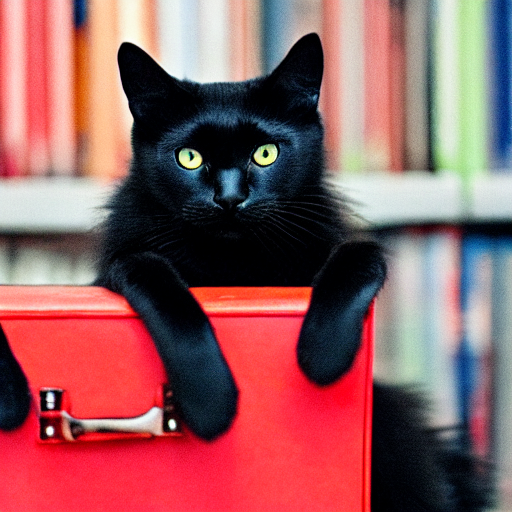

In [30]:
# Choose example ID here!
example_id = 5

# Read 
example_dict = examples[example_id]
prompt = example_dict['prompt']
token_indices = example_dict['indices']#[2,5] # 
color_index_list = example_dict['color_indices'] # None if there are no attributes
seeds = example_dict['seed']
loss_mode = example_dict['loss_mode']


#################
# Loss related  #
#################
do_optimization = True #False -> switch to normal SD

loss_mode_avail_list  = ['max', 'tv', 'tv_bind']
#loss_mode = 'max' # Attend and Excite
#loss_mode = 'tv'
#loss_mode = 'tv_bind'
assert loss_mode in loss_mode_avail_list

###################################
# Attention visualizaton related  #
###################################
save_attn_vis = False #  change here if do not want to save attention vis!  
pickle_store_timestep_list=None #[25,50] # if storing attention maps in pickle
save_attn_everystep = False
keep_timestep_list = [5,25,40] # None if do not need attention visualization
store_every_step = False

########################################
# Optimization related hyperparameters #
########################################  
max_iter_to_alter = 25 
display_output = True
loss_parm_dict = default_param(loss_mode)


# Avoid memory explosion
try:
    del controller
except:
    pass

for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    img_name = prompt.replace(" ", "_")[:50]
    img_name += f'_seed{seed}'
    if do_optimization:
        img_name += f'_opt_{loss_mode}'
    output_dir_name =os.path.join(output_dir, img_name)
    img_name += '.png'
    
    from utils.ptp_utils import AttentionStore
    
    controller = AttentionStore(
        store_every_step=store_every_step,
        output_dir=output_dir_name,
        pickle_store_timestep_list=pickle_store_timestep_list,
        keep_timestep_list=keep_timestep_list,
        save_attn_vis=save_attn_vis, 
    )
    
    run_standard_sd = False if do_optimization else True
    image = run_and_display(
        model=stable,
        prompts=prompts, 
        controller=controller,
        indices_to_alter=token_indices,
        generator=g, 
        run_standard_sd=run_standard_sd,
        save_attn_everystep=save_attn_everystep,
        display_output=display_output,
        thresholds=loss_parm_dict['thresholds'], 
        max_iter_to_alter=max_iter_to_alter,
        loss_mode=loss_mode,
        max_refinement_steps_init_step=loss_parm_dict['max_refinement_steps_init_step'],
        color_index_list = color_index_list,
        threshold_indicator=loss_parm_dict['threshold_indicator'],
    )
    image_name = os.path.join(output_dir,img_name)
    image.save(image_name)